In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d7aunfc0 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_patients = pd.read_csv('data/diabetic_data_processed_2.csv',index_col='patient_nbr')
df_patients.shape

(69990, 84)

In [3]:
X = df_patients.drop('readmitted',axis=1)
y = df_patients['readmitted']
X.shape, y.shape

((69990, 83), (69990,))

**Note on Class Imbalance**

There is class imbalance of 95% / 5% in this dataset.  Google describes this as ‘moderate’ imbalance, with its definition of ‘extreme’ being < 1% minority class.  Balancing classes via class weights (scale_pos_weight in XGBoost) or oversampling (SMOTE)/undersampling only marginally increased AUC-ROCs at the expense of calibration for models such as logistic regression and did not improve AUC for XGBoost.  This result is consistent with the findings of the 2022  paper "To Smote or not to Smote?" (https://arxiv.org/pdf/2201.08528.pdf), which provides evidence that for strong state of the art learners, such as XGBoost, balancing does not generally help performance. XGBoost documentation also recommends that if calibration is one of the key performance metrics of interest (which it is in this case), then not to use scale_pos_weight parameter.

In [38]:
y.value_counts(normalize=True)

readmitted
0    0.950436
1    0.049564
Name: proportion, dtype: float64

**Notes on Train/Test Split**

XGBoost's early stopping mechanism does not work well with CV so here we create a separate validation set for hyperparameter tuning.

Also, note that we use 'stratify' to duplicate the class imbalance in training, val and test sets.

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                              X, y, 
                                                              random_state=109,
                                                              stratify=y,                                          
                                                              test_size = 0.2 
                                                             )
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  random_state=109,
                                                  stratify=y_train_full,                                          
                                                  test_size = 0.25)
X_train.shape,y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape


((41994, 83), (41994,), (13998, 83), (13998,), (13998, 83), (13998,))

**XGBoost: Categorical Variables Handling**

One of the benefits of using XGBoost is that, unlike sklearn models, it provides native support for categorical variables without the need for numerical encoding, as long as categorical variables are set to type 'category' and enable_categorical parameter is set to True in XGBoost.

However, downstream tasks such as calculating Permutation Importance and SHAP values require numerical encoding.  Instead of using one hot encoding and exploding the feature space, here we use cat.codes and ordinally encode categoricals - the difference in performance between these two approaches is not meaningful (as was discussed in class) for tree based models


In [44]:

def prep_cat(X):
    cat_to_codes = dict()
    for col in X.select_dtypes('object'):
        X[col] = X[col].astype('category')
        #Store the encodings 
        cat_to_codes[col] = dict(sorted(zip(X[col].cat.codes,X[col])))
        #Source: Kaggle
        #This is not necessary for XGBoost (as described above) but is done to facilitate downstream tasks 
        #(Permutation Importance, etc.)
        X[col] = X[col].cat.codes
    return cat_to_codes


In [ ]:
cat_to_codes=prep_cat(X_train)
prep_cat(X_val)
prep_cat(X_test)
prep_cat(X_train_full)

In [6]:
def print_stats(dataset_type, model, X, y):
    y_pred_prob = model.predict_proba(X)[:,1]
    print(f'------------------{dataset_type}----------------------')
    print(f'Readmitted Rate:\tActual:{np.round(np.mean(y),4)}\tPredicted:{np.round(np.mean(y_pred_prob),4)}')
    print(f'Accuracy:\t\tNaive:{np.round(1-np.mean(y),3)}\tBase Model:{np.round(model.score(X,y),3)}')
    print(f'AUC:\t\t\t{np.round(roc_auc_score(y, y_pred_prob),3)}')

In [8]:
import xgboost as xgb

#Measure performance of XGBoost w/o hyperparameter tuning
xgb_base = xgb.XGBClassifier(enable_categorical=True)
xgb_base.fit(X_train,y_train)
print_stats('TRAIN_FULL',xgb_base,X_train_full,y_train_full)
print_stats('TEST',xgb_base,X_test,y_test)


------------------TRAIN_FULL----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.04830000177025795
Accuracy:		Naive:0.95	Base Model:0.961
AUC:			0.887
------------------TEST----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.02280000038444996
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.676


**XGBoost Hyperparameter Tuning**

Based on Kaggle, a clever way to tune the n_estimators parameter (# of boosing iterations) is to pick a really large number like 10,000 and use early stopping to break out before the model starts overfitting.  Note: boosting models are vulnerable to overfitting with increasing number of trees, unlike random forest or bagging.

The creator of the XGBoost implementation in R (https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) notes that the three most important parameters to tune are number of estimators, learning rate, and max depth.  When we noticed overfitting, we further tried tuning gamma (which regularizes) as well as subsample (which selects only sub sample of the data for each of the trees) but found no meaningful difference in final AUCs.

XGBoost documentation says that using early stopping feature with CV causes issues so we use the validation set, which is large enough here, to assess performance of hyperparameter tuning.

In [9]:
def get_best_params(X_train,y_train,X_val,y_val,scale_pos_weight=1,verbose=True):
    val_aucs = []
    params = []
    
    for max_depth in range(1,9):
        for eta in [0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                        eval_metric='auc',
                                        n_estimators=10000,
                                        learning_rate=eta,
                                        max_depth=max_depth,
                                        enable_categorical=True,
                                        early_stopping_rounds=30,
                                        n_jobs=-1,
                                        scale_pos_weight=scale_pos_weight)
            xgb_clf.fit(X_train,y_train,
                       eval_set=[(X_train,y_train),(X_val,y_val)],
                       verbose=False)
            val_aucs.append(xgb_clf.best_score)
            params.append({'n_estimators':xgb_clf.best_iteration,'learning_rate':eta,'max_depth':max_depth})
            if verbose:
                print(f'{xgb_clf.best_score}\tn_estimators:{xgb_clf.best_iteration}\t\teta:{eta}\tmax_depth:{max_depth}')
                
    best_idx = np.argmax(val_aucs)
    return params[best_idx]
        
                                      

In [10]:
xgb_best_params = get_best_params(X_train,y_train,X_val,y_val)

0.5741462990914306	n_estimators:0		eta:0.001	max_depth:1
0.5741462990914306	n_estimators:0		eta:0.005	max_depth:1
0.5741462990914306	n_estimators:0		eta:0.01	max_depth:1
0.693604911352526	n_estimators:755		eta:0.05	max_depth:1
0.6939307542876749	n_estimators:413		eta:0.1	max_depth:1
0.6951526788329137	n_estimators:323		eta:0.2	max_depth:1
0.692205579219528	n_estimators:55		eta:0.3	max_depth:1
0.6943408604116376	n_estimators:90		eta:0.4	max_depth:1
0.6946759636329608	n_estimators:108		eta:0.5	max_depth:1
0.6274428201697914	n_estimators:11		eta:0.001	max_depth:2
0.6274428201697914	n_estimators:3		eta:0.005	max_depth:2
0.6274428201697914	n_estimators:2		eta:0.01	max_depth:2
0.7165133430434564	n_estimators:554		eta:0.05	max_depth:2
0.7127702378951272	n_estimators:145		eta:0.1	max_depth:2
0.7178474199434722	n_estimators:229		eta:0.2	max_depth:2
0.7182305575147168	n_estimators:72		eta:0.3	max_depth:2
0.7209518361143796	n_estimators:78		eta:0.4	max_depth:2
0.7151710889316727	n_estimators:64		

In [11]:
xgb_best_params

{'n_estimators': 78, 'learning_rate': 0.4, 'max_depth': 2}

The highest val AUC of 72% was with the aforementioned parameters.  However, max_depth 2 does not seem sufficient to convey the expressiveness of the model so we decided to go with the XGBoost default max depth 6 with the corresponding eta of 0.05 and 123 estimators, which resulted in the val set AUC of 71.9%, which is very close to the highest 72%.

In [13]:
xgb_tuned = xgb.XGBClassifier(n_estimators=123,eta=0.05,max_depth=6,
                              enable_categorical=True,
                              objective='binary:logistic',
                             eval_metric='auc')
xgb_tuned.fit(X_train_full,y_train_full)
print_stats('TRAIN-FULL',xgb_tuned,X_train_full,y_train_full)
print_stats('TEST',xgb_tuned,X_test,y_test)

------------------TRAIN-FULL----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.04969999939203262
Accuracy:		Naive:0.95	Base Model:0.952
AUC:			0.831
------------------TEST----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.04899999871850014
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.721


**Distribution of Probabilities of Readmission**

It is useful to look at the distribution of the predicted probabilities.

This helps us form our initial recommendation to the client: Medical Team should prioritize interventions or follow-ups for the 34% of the patients predicted to have higher chance than average (5%) of being readmitted early

Also, the probability distribution produced by the model in production should be monitored over time.  Changes in this distribution would indicate that model needs to be retrained


'Min/Max: 0.004000000189989805, 0.6779999732971191'

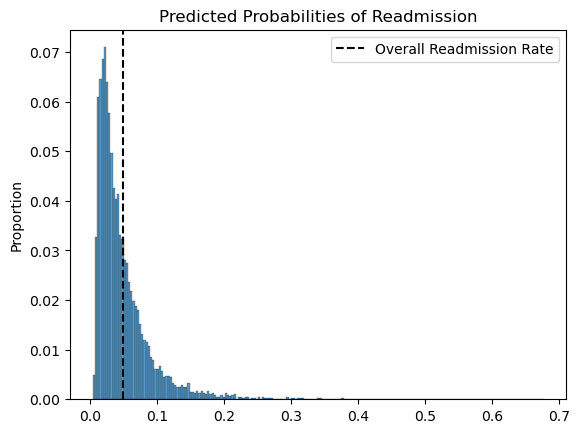

In [14]:
y_test_prob = xgb_tuned.predict_proba(X_test)[:,1]
display(f'Min/Max: {round(np.min(y_test_prob),3)}, {round(np.max(y_test_prob),3)}')
ax = sns.histplot(y_test_prob,stat='proportion');
ax.axvline(x=y_test_prob.sum()/y_test_prob.shape[0],linestyle='--',color='black',
           label='Overall Readmission Rate')
ax.set_title('Predicted Probabilities of Readmission')
ax.legend();

**Model Calibration**

Note that the recommendation above (that we should prioritize patients with above average overall readmittance rate of 5%) is reliable only if the probabilities predicted by the model are reliable.  So not only do we want the model to reasonably rank patients in terms of risk (measured by AUC) but we also want the model to output probabilities close to actuals (calibration).

See another example of how looking at calibration can be useful (towards the end of the notebook) in determining how fair the ML model is

The two graphs below show that the model is reasonably well calibrated.  In the bar chart on the left, note that each of the bars (predicted vs. actual for that decile) is close to each other.  In the kde plot on the right, the distributions are close to each other.

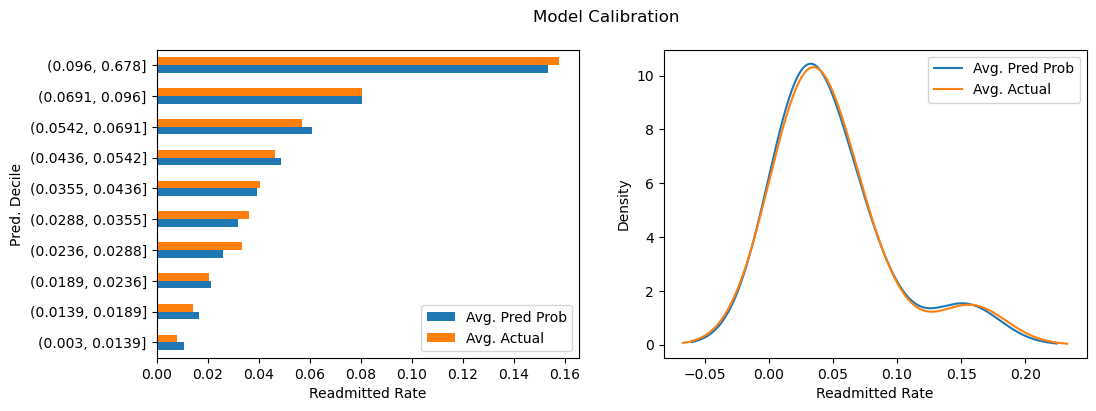

In [15]:
import matplotlib.pyplot as plt

def by_deciles(y_actual,y_probs_pred):
    deciles = pd.qcut(x=y_probs_pred,q=10)
    combine_df = pd.DataFrame(data={'Pred. Decile':deciles,
                                    'Avg. Pred Prob':y_probs_pred,
                                    'Avg. Actual':y_actual})
    by_decile_df = combine_df.groupby('Pred. Decile').mean()
    by_decile_df.reset_index(inplace=True)
    by_decile_df["Pred. Decile"] = by_decile_df["Pred. Decile"] \
                                      .apply(lambda x: pd.Interval(left=round(x.left,4), 
                                                                   right=round(x.right,4)))
    return by_decile_df

by_decile_df = by_deciles(y_test,y_test_prob)
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='barh',
                  ax=axes[0])
by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='kde',
                  ax=axes[1])
axes[0].set_xlabel('Readmitted Rate')
axes[1].set_xlabel('Readmitted Rate')
fig.suptitle('Model Calibration');


**Model Interpretation: Permutation Imoportance vs. Shap Values**

To interpret the model, we look at feature importance from both permutation importance and shap values.  

Top features associated with risk of being readmitted early include demographic factors (age and race),  medical history (# of previous visits, # of current conditions, etc.), as well as where the patient is discharged to (home, nursing home, etc.)

Permutation importance and Shap feature importance generally agree in the top features associated with high risk patient, with some feature reordering between the two methods

Shap values provide additional useful information such as how feature value affects risk.  For example, for age high values (red) reflect high Shap values which in turn reflect higher risk


In [17]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(xgb_tuned, random_state=109, scoring='roc_auc') \
                            .fit(X_train_full,y_train_full)
eli5.show_weights(perm, feature_names = X_train_full.columns.tolist())

Weight,Feature
0.0931 ± 0.0061,number_inpatient
0.0469 ± 0.0032,discharge_disposition_id
0.0288 ± 0.0032,num_lab_procedures
0.0217 ± 0.0009,age
0.0194 ± 0.0018,medical_specialty
0.0138 ± 0.0016,number_diagnoses
0.0110 ± 0.0015,time_in_hospital
0.0107 ± 0.0006,diag_1
0.0105 ± 0.0013,num_medications
0.0099 ± 0.0008,race


In [ ]:
from shap.explainers import Tree


#Reference: Python Projects for Data Science, Second Edition
shap_explainer = Tree(xgb_tuned, data=X_train_full)
shap_values = shap_explainer(X_train_full)
shap_values.values.shape

[21:14:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 29%|======              | 16269/55992 [01:17<03:08]       

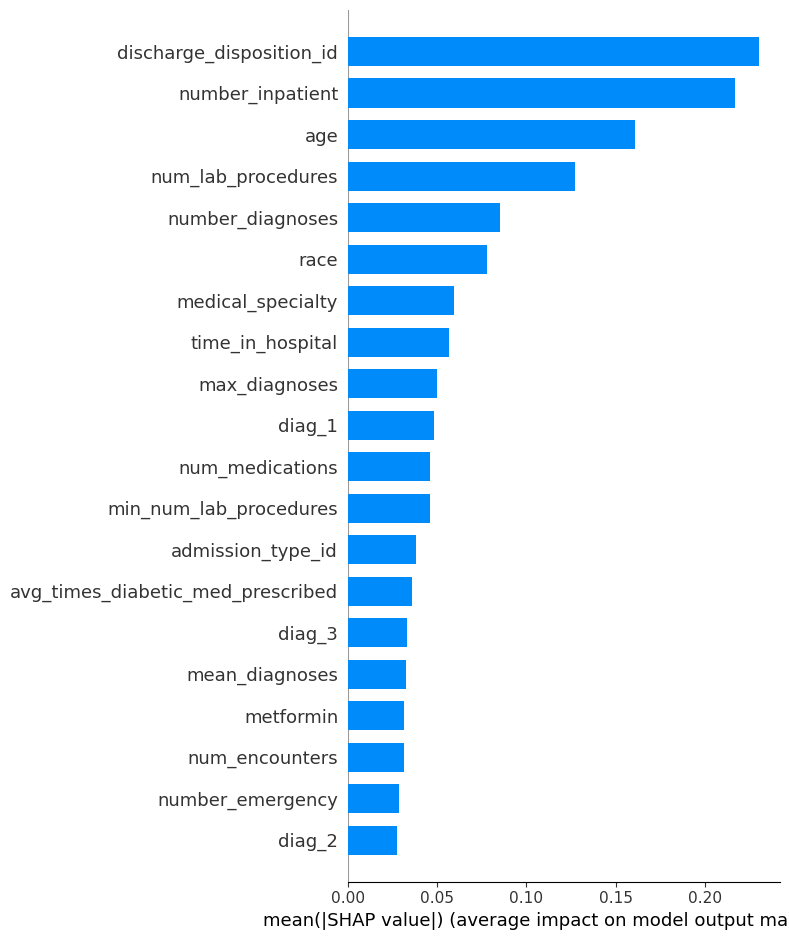

NoneType

In [19]:
import shap
type(shap.summary_plot(shap_values.values,X_train_full,plot_type='bar'))

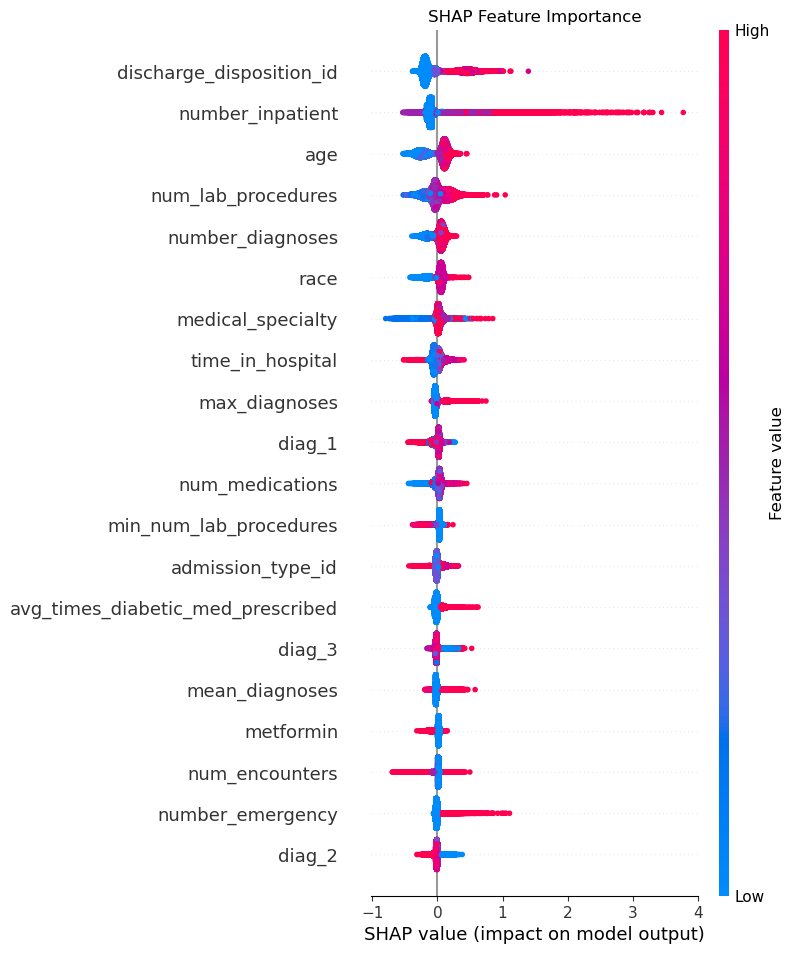

In [20]:
import shap
shap.summary_plot(shap_values.values,X_train_full,show=False)
plt.title('SHAP Feature Importance')
plt.show();

**Discharge Disposition**

Patients discharged to skilled nursing facilities are at higher risk (above 0 SHAP values) than those discharged to their homes (below 0 SHAP values)

{0: 'Home', 1: 'Home w/ Service', 2: 'Other', 3: 'SNF'}

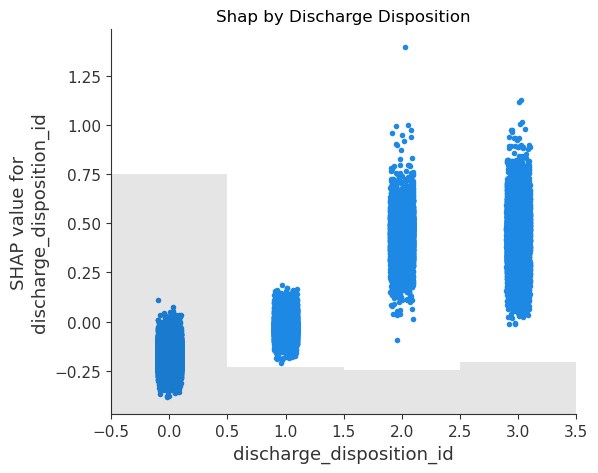

In [42]:
display(cat_to_codes['discharge_disposition_id'])
shap.plots.scatter(shap_values[:,'discharge_disposition_id'],show=False)
plt.title('Shap by Discharge Disposition')
plt.show()

**# of Inpatients Visits in Preceding Year**

Higher the number of inpatient visits in the preceding year, greater the chances of being readmitted early (since the SHAP values positively slope with increased value of visits)

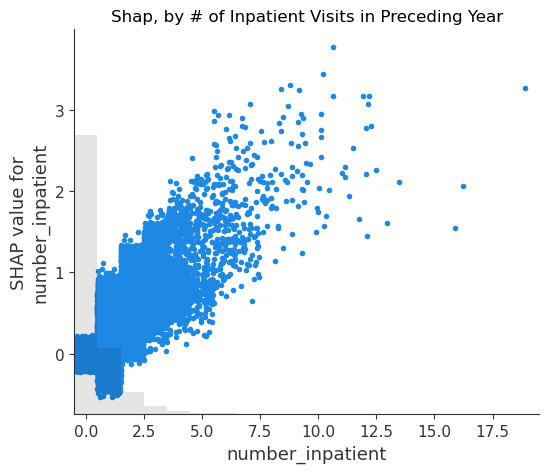

In [26]:
shap.plots.scatter(shap_values[:,'number_inpatient'],x_jitter=1,show=False)
plt.title('Shap, by # of Inpatient Visits in Preceding Year')
plt.show()

**Age**

Not surprisingly, risk of early remittance increases with age for patients older than 60 (>0 Shap values).

{0: '[0-50)', 1: '[50-60)', 2: '[60-70)', 3: '[70-80)', 4: '[80-100)'}

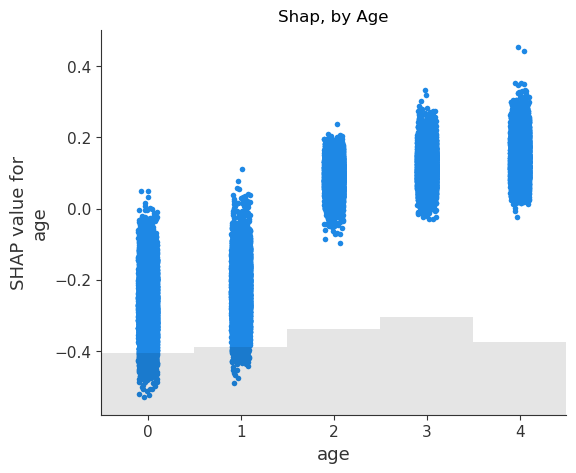

In [30]:
display(cat_to_codes['age'])
shap.plots.scatter(shap_values[:,'age'],show=False)
plt.title('Shap, by Age')
plt.show()

**Number of Diagnoses (x Age)**

Risk increases with increasing number of existing conditions until about 7 conditions after which point the risk plateaus.

Also, note that SHAP found an interaction with age: Unless patient is older than 60, having fewer than four diagnoses 
reduces risk of early readmittance.

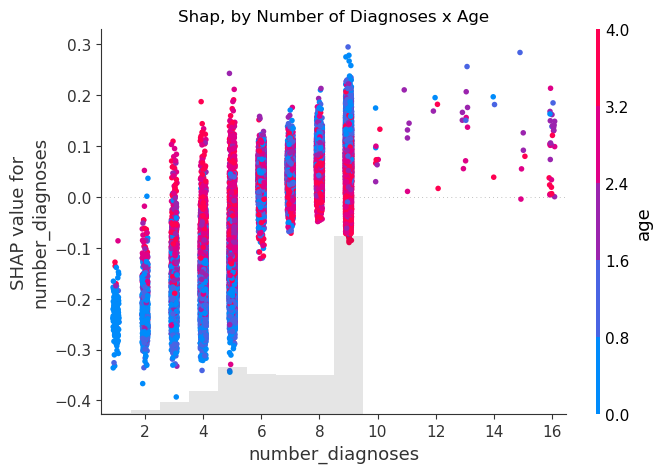

In [33]:
shap.plots.scatter(shap_values[:,'number_diagnoses'],
                   color=shap_values, show=False)
plt.title('Shap, by Number of Diagnoses x Age')
plt.show()

**ML Model Fairness**

While African American patients are generally less likely to be readmitted early based on Shap values, model is not as well calibrated for them as it is for Caucasians, leading to meaningful under-predictions for the former group in some cases

Specifically, bulk of Shap values for African American patients are well below zero, suggesting that they are the least likely to be readmitted early and should not be prioritized for interventions, relative to patients of other races, including Caucasians who are disproportionately over-represented in this dataset

However, model is not as well calibrated for African Americans as it is for Caucasians, with meaningful under-predictions in deciles with probabilities 2%-3%.  This noise is likely caused by training model on disproportionately smaller number of examples with African Americans 

{0: 'AfricanAmerican',
 1: 'Asian',
 2: 'Caucasian',
 3: 'Hispanic',
 4: 'Other',
 5: 'UNK'}

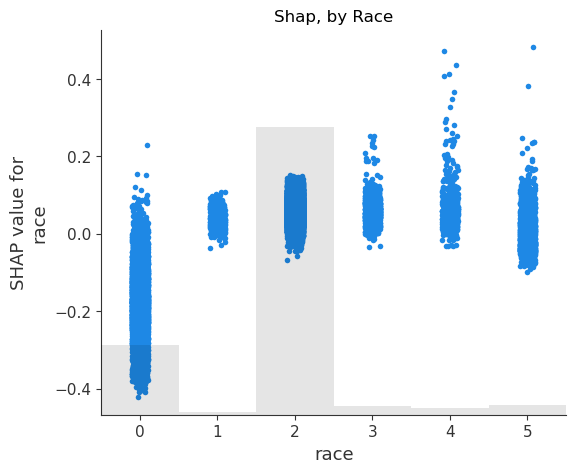

In [29]:
display(cat_to_codes['race'])
shap.plots.scatter(shap_values[:,'race'],show=False)
plt.title('Shap, by Race')
plt.show()

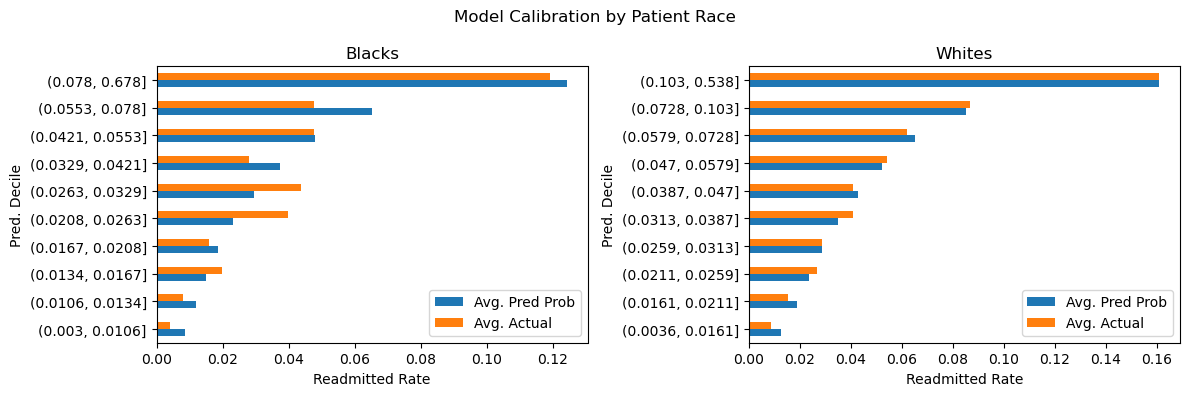

In [16]:
black_by_decile_df = by_deciles(y_test[X_test['race']==0],y_test_prob[X_test['race']==0])
white_by_decile_df = by_deciles(y_test[X_test['race']==2],y_test_prob[X_test['race']==2])
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
black_by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='barh',
                  ax=axes[0]).set_title('Blacks')
white_by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='barh',
                  ax=axes[1]).set_title('Whites')
axes[0].set_xlabel('Readmitted Rate')
axes[1].set_xlabel('Readmitted Rate')
fig.suptitle('Model Calibration by Patient Race')
plt.tight_layout();